In [1]:
# -*- coding: utf-8 -*- 
import pandas as pd
import math
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score,roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler,LabelBinarizer
from sklearn.datasets import fetch_20newsgroups, load_files
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.learning_curve import validation_curve,learning_curve

import xgboost as xgb
from evolutionary_search import EvolutionaryAlgorithmSearchCV

%matplotlib inline

#import sys  
#reload(sys)  
#sys.setdefaultencoding('utf-8')

# настройка внешнего вида графиков в seaborn
sns.set_style("dark")
sns.set_palette("RdBu")
sns.set_context("notebook", font_scale = 1.5, 
                rc = { "figure.figsize" : (15, 5), "axes.titlesize" : 18 })


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


** Описание набора данных **

** Список переменных **

1 - id	идентификатор.  
2 - taxactionSystem	 система налогообложения (категориальный).  
3 - regdt  Дата регистрации (число).  
4 - workerCount   количество сотрудников (число).  
5 - fssdccount   количество отправленных отчетов в ФСС из этой организации из БК за все время существования (число).  
6 - pfrdcCount   количество отправленных отчетов в ПФР из этой организации из БК за все время существования (число).  
7 - fnsdcCount   количество отправленных отчетов в ФНС из этой организации из БК за все время существования (число).  
8 - hasCloudCryptCertificate   был ли когда-либо в этой организации выпущен облачный сертификат (бинарный).  
9 - OrgCreationDate  дата добавления организации в БК Это не дата регистрации организации в ФНС и т.д., это дата, когда организация была добавлена (создана) в БК (число).  
10 - documentsCount  количество документов. Считает количество документов в системе (которые показываются на вкладке ""Все"") в этом количестве учитываются не все документы ) (число).  
11 - cnt_users   количество пользователей (число).  

Целевая переменная 12 - is_prolong  - продлится пользователь или нет. (бинарная: 1, 0)

Формат файла ответов:  
id, is_prolong  

In [2]:
train=pd.read_csv('train.csv',sep='\t',encoding='cp1251',parse_dates=['regdt','OrgCreationDate'])
test=pd.read_csv('test.csv',sep='\t',encoding='cp1251',parse_dates=['regdt','OrgCreationDate'])
train.head()

,id,taxactionSystem,regdt,workerCount,fssdccount,pfrdcCount,fnsdcCount,hasCloudCryptCertificate,OrgCreationDate,documentsCount,cnt_users,is_prolong
0,101969,"УСН, Доходы 6%",1994-03-26,5.0,0.0,0.0,0.0,0,2014-04-12,2.0,0.0,1.0
1,108477,ОСНО,2012-12-05,1.0,0.0,0.0,0.0,0,2014-09-22,5.0,0.0,0.0
2,101476,"УСН, Доходы 6%",2009-11-15,1.0,3.0,3.0,2.0,0,2016-05-04,0.0,0.0,1.0
3,102579,"УСН, Доходы за вычетом расходов 15%",2015-08-09,1.0,0.0,0.0,0.0,0,2015-09-24,0.0,0.0,0.0
4,103110,"УСН, Доходы за вычетом расходов 15%",2015-03-29,0.0,0.0,0.0,0.0,0,2015-03-04,4.0,0.0,0.0


**Выводим основные харакетристики переменных;**

In [3]:
print(train.shape)
train.describe(include = "all").T

(7626, 12)


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
id,7626,NaN,NaN,NaN,NaN,NaN,105076,2937.32,100001,102548,105056,107638,110167
taxactionSystem,7626,23,ОСНО,2752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
regdt,7626,3030,2015-01-10,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
workerCount,7626,NaN,NaN,NaN,NaN,NaN,0.900865,1.03024,0,0,1,1,6
fssdccount,7626,NaN,NaN,NaN,NaN,NaN,0.818778,0.82958,0,0,1,2,3
pfrdcCount,7626,NaN,NaN,NaN,NaN,NaN,0.833071,0.942024,0,0,1,2,4
fnsdcCount,7626,NaN,NaN,NaN,NaN,NaN,1.16444,1.03625,0,0,1,2,4
hasCloudCryptCertificate,7626,NaN,NaN,NaN,NaN,NaN,0.514293,0.499828,0,0,1,1,1
OrgCreationDate,7626,737,1900-01-01 00:00:00,1264,1900-01-01 00:00:00,2016-12-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
documentsCount,7626,NaN,NaN,NaN,NaN,NaN,4.07933,2.74458,0,1,5,6,10


**Визуализируем данные**

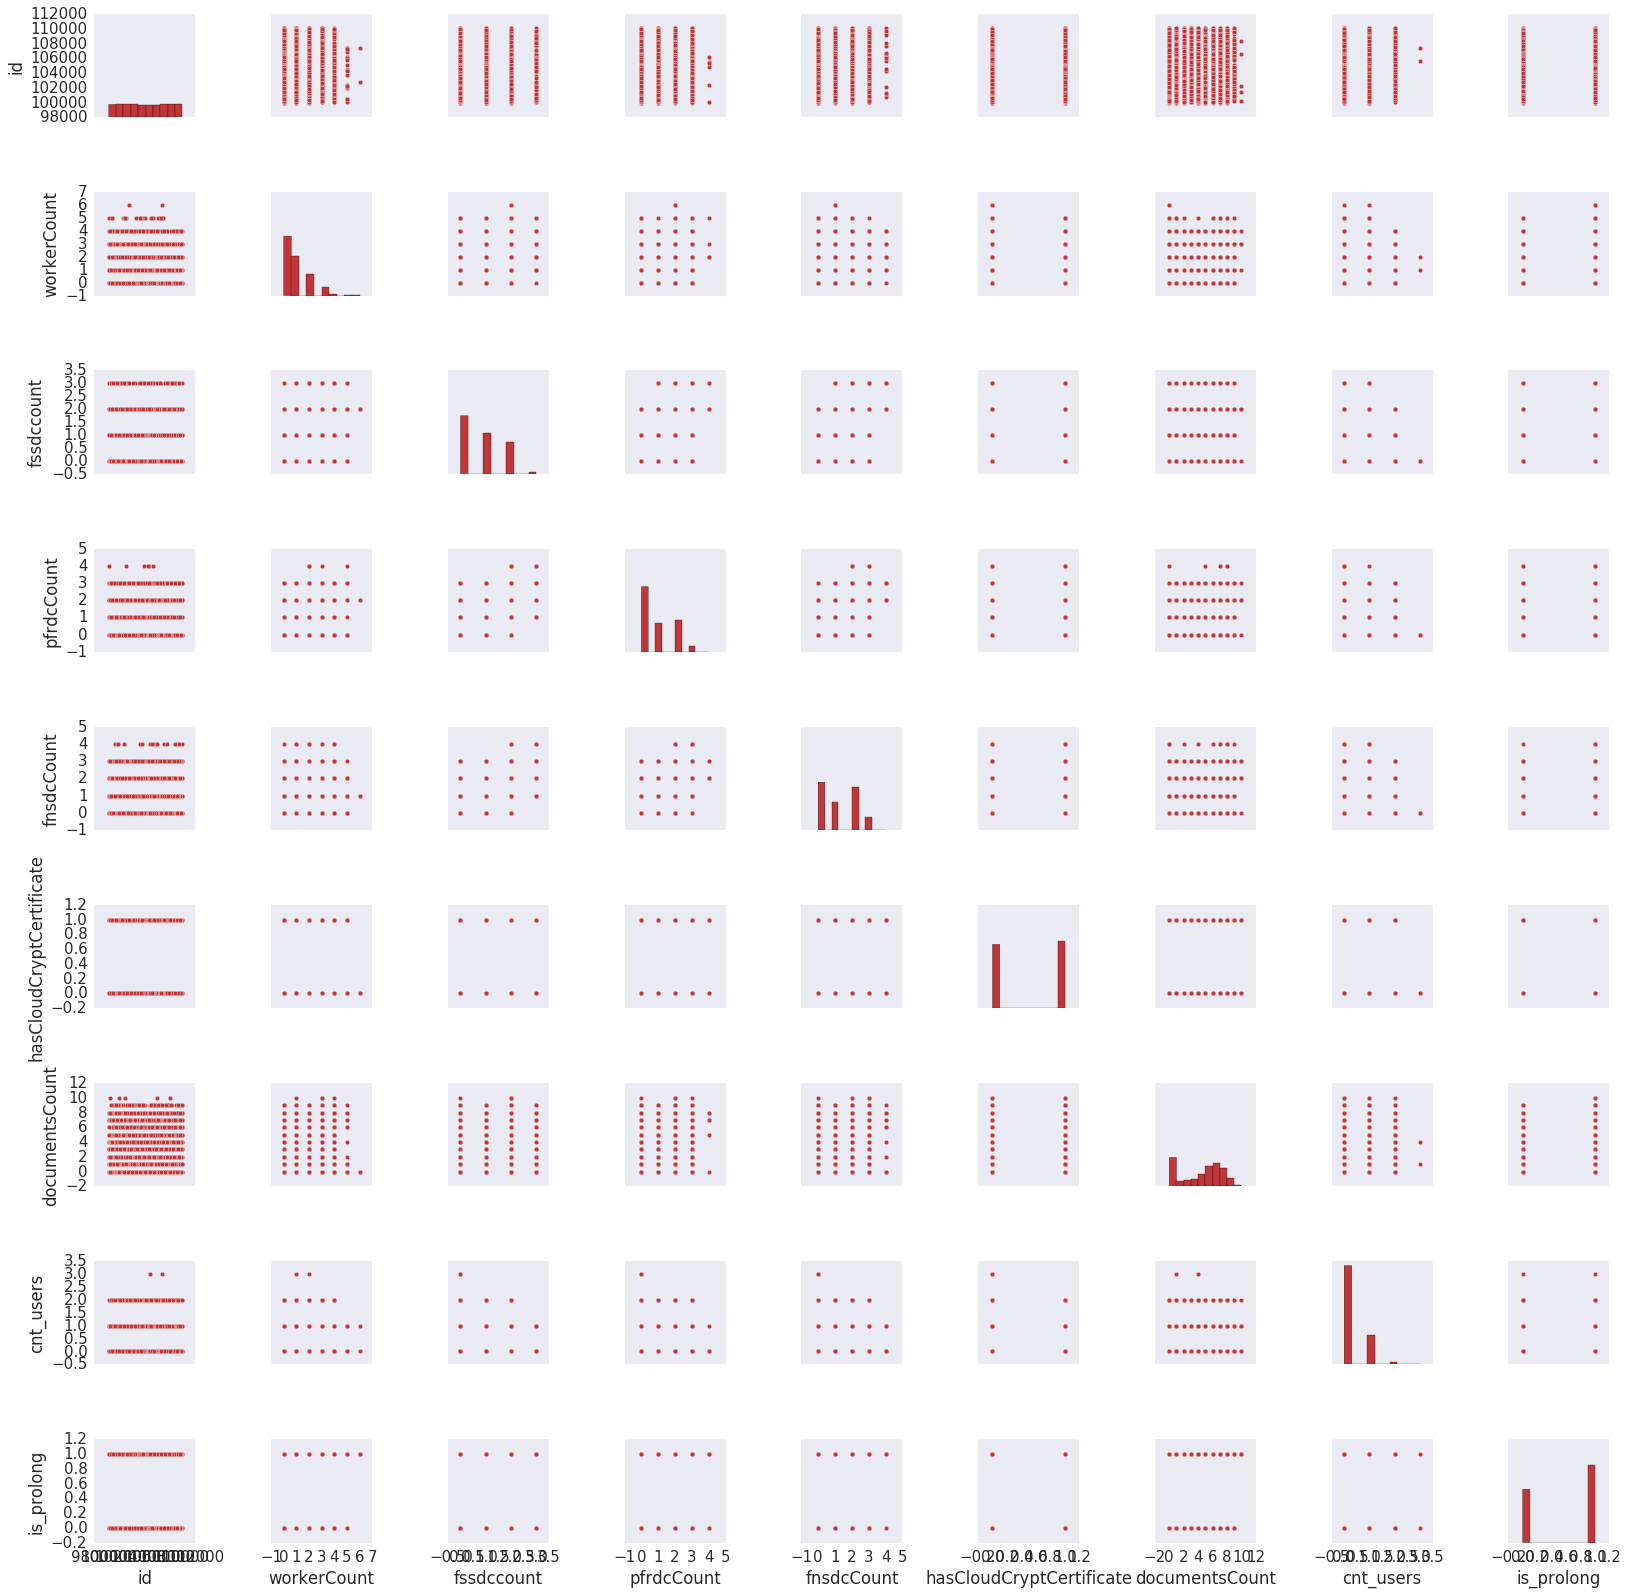

In [4]:
sns.pairplot(train)

### Предобработка данных

In [4]:
#Удалим столбец id, так как он не несет никакой информации
train.drop(columns=['id'],axis=1,inplace=True)
#удалим строчки с кривой датой
train.drop(axis=0,index=train[train['regdt']=='0001-01-01 00:00:00.0000000']['regdt'].index.values,inplace=True)
#приведем дату в нужный формат
train[['regdt','OrgCreationDate']]=train[['regdt','OrgCreationDate']].apply(pd.to_datetime)
#удалим строчки с пропущенными значениями (т.к их мало)
train.dropna(axis=0, how='any',inplace=True)

#Приведем колонки к формату int
columns = train.select_dtypes(['floating']).columns
train[columns] = train[columns].astype('int64')

#Работаем с датой, достанем год, месяц, день
train['regdt_year']=pd.DatetimeIndex(train['regdt']).year
train['regdt_month']=pd.DatetimeIndex(train['regdt']).month
train['regdt_day']=pd.DatetimeIndex(train['regdt']).day

train['OrgCreationDate_year']=pd.DatetimeIndex(train['OrgCreationDate']).year
train['OrgCreationDate_month']=pd.DatetimeIndex(train['OrgCreationDate']).month
train['OrgCreationDate_day']=pd.DatetimeIndex(train['OrgCreationDate']).day

#Попробуем добавить кол-во лет с момента регистрации
train['today-regdt_year']=2018-train['regdt_year']
train['today-OrgCreationDate_year']=2018-train['OrgCreationDate_year']

train.drop(axis=1,columns=['regdt','OrgCreationDate'],inplace=True)

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7598 entries, 0 to 7625
Data columns (total 17 columns):
taxactionSystem               7598 non-null object
workerCount                   7598 non-null int64
fssdccount                    7598 non-null int64
pfrdcCount                    7598 non-null int64
fnsdcCount                    7598 non-null int64
hasCloudCryptCertificate      7598 non-null int64
documentsCount                7598 non-null int64
cnt_users                     7598 non-null int64
is_prolong                    7598 non-null int64
regdt_year                    7598 non-null int64
regdt_month                   7598 non-null int64
regdt_day                     7598 non-null int64
OrgCreationDate_year          7598 non-null int64
OrgCreationDate_month         7598 non-null int64
OrgCreationDate_day           7598 non-null int64
today-regdt_year              7598 non-null int64
today-OrgCreationDate_year    7598 non-null int64
dtypes: int64(16), object(1)
memory usage:

**Достанем из признака taxactionSystem систему налогооблажения и величину ставки**

In [5]:
new_tax=pd.DataFrame(columns=['tax','stavka'])
for idx,i in enumerate(train.taxactionSystem):
    temp=i.split(', ')
    if len(temp)!=2:
        new_tax.loc[idx]=[temp[0],0]
    else:
        new_tax.loc[idx]=[temp[0],int(str(re.search(r'\d+%', temp[1]).group(0))[:-1])]

In [6]:
train['tax']=new_tax['tax']
train['stavka']=new_tax['stavka']
train.drop(columns='taxactionSystem',axis=1,inplace=True)

In [7]:
train.dropna(axis=0, how='any',inplace=True)
train['stavka'] = train['stavka'].astype('int64')
train.head()

,workerCount,fssdccount,pfrdcCount,fnsdcCount,hasCloudCryptCertificate,documentsCount,cnt_users,is_prolong,regdt_year,regdt_month,regdt_day,OrgCreationDate_year,OrgCreationDate_month,OrgCreationDate_day,today-regdt_year,today-OrgCreationDate_year,tax,stavka
0,5,0,0,0,0,2,0,1,1994,3,26,2014,4,12,24,4,УСН,6
1,1,0,0,0,0,5,0,0,2012,12,5,2014,9,22,6,4,ОСНО,0
2,1,3,3,2,0,0,0,1,2009,11,15,2016,5,4,9,2,УСН,6
3,1,0,0,0,0,0,0,0,2015,8,9,2015,9,24,3,3,УСН,15
4,0,0,0,0,0,4,0,0,2015,3,29,2015,3,4,3,3,УСН,15


# Посмотрим на данные

Распределение целевой переменной: 	


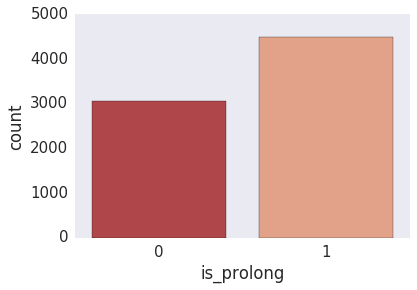

In [8]:
print 'Распределение целевой переменной: \t'
sns.countplot(train.is_prolong)

Дисбаланса классов практически нет, поэтому можем использовать метрику accuracy

## One hot encoding

Применим one hot encoding для категориального признака tax

{0: u'\u0415\u041d\u0412\u0414', 1: u'\u041e\u0421\u041d\u041e', 2: u'\u0423\u0421\u041d'}


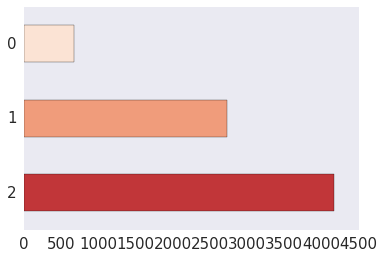

In [8]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(np.hstack((train['tax']))))
mapped_education.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

In [9]:
# integer encode
integer_encoded = label_encoder.fit_transform(train['tax']).astype('int')
print integer_encoded
#train['tax']=integer_encoded


[2 1 2 ..., 0 2 2]


In [10]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded[:5])

# invert first example
inverted = label_encoder.inverse_transform([np.argmax(onehot_encoded[0, :])])
print(inverted)

train=train.join(pd.DataFrame(onehot_encoded,columns=["tax"+str(i) for i in range(onehot_encoded.shape[1])]),how='outer')
train.drop(columns='tax',axis=1,inplace=True)
train.dropna(axis=0, how='any',inplace=True)
train[train.columns] = train[train.columns].astype('int64')

[[ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]
[u'\u0423\u0421\u041d']


### Корреляция

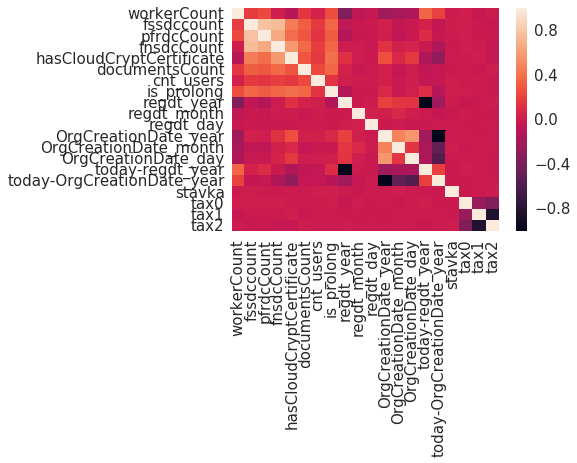

In [12]:
sns.heatmap(train.corr(method='pearson'),xticklabels=True,yticklabels=True);

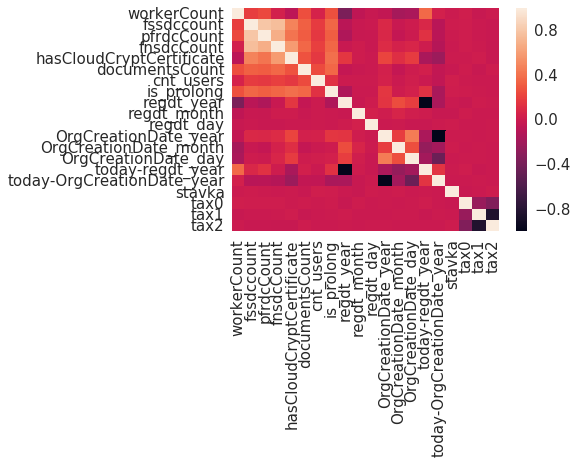

In [15]:
sns.heatmap(train.corr(method='spearman'),xticklabels=True,yticklabels=True);

**Удалим целевой столбец**

In [11]:
target=train.is_prolong
train.drop(axis=1,columns=['is_prolong'],inplace=True)

### Метрика

In [12]:
def getROC_AUC(method,test_X,test_y):
    precision, recall, thresholds = precision_recall_curve(test_y, method.predict_proba(test_X)[:,1])
    plt.title("precision-recall")
    plt.plot(recall,precision)

    fpr, tpr, thresholds = roc_curve(test_y, method.predict_proba(test_X)[:,1])
    plt.figure()
    plt.title("ROC-AUC")
    plt.plot(fpr,tpr)

**Разделим выборку на обучающую и тестовую**

In [54]:
train_X,test_X,train_y,test_y=train_test_split(train,target,shuffle=True,random_state=17,test_size=0.2)

## Логистическая регрессия

Попробуем применить LR с подбором параметров с помощью EvolutionaryAlgorithmSearchCV

In [37]:
lr=LogisticRegression(n_jobs=-1)
lr_pipe = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression())])

paramgrid = {"lr__C": np.logspace(-8, 1, 10),
             "lr__penalty"     : ['l1','l2']}

np.random.seed(17)

cv = EvolutionaryAlgorithmSearchCV(estimator=lr_pipe,
                                   params=paramgrid,
                                   scoring="accuracy",
                                   cv=StratifiedKFold(n_splits=4),
                                   verbose=1,
                                   population_size=10,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=10,
                                   n_jobs=8)
cv.fit(train_X, train_y)

Types [1, 2] and maxint [1, 9] detected


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by Stand

--- Evolve in 20 possible combinations ---
gen	nevals	avg     	min    	max     	std     
0  	10    	0.637809	0.40295	0.754517	0.154365
1  	6     	0.743362	0.719874	0.754517	0.0153965
2  	8     	0.753141	0.752528	0.754517	0.000901957
3  	5     	0.75392 	0.752528	0.754517	0.000911502
4  	6     	0.754517	0.754517	0.754517	1.11022e-16
5  	8     	0.754318	0.752528	0.754517	0.000596718
6  	9     	0.754517	0.754517	0.754517	1.11022e-16
7  	7     	0.754517	0.754517	0.754517	1.11022e-16
8  	6     	0.754517	0.754517	0.754517	1.11022e-16
9  	6     	0.754517	0.754517	0.754517	1.11022e-16
10 	8     	0.75455 	0.754517	0.754848	9.9453e-05 
Best individual is: {'lr__penalty': 'l2', 'lr__C': 10.0}
with fitness: 0.754848334162


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Построим модель с лучшими параметрами

0.755467196819
0.742684491049


/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


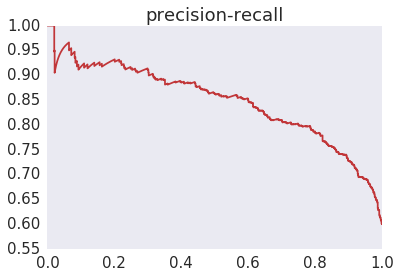

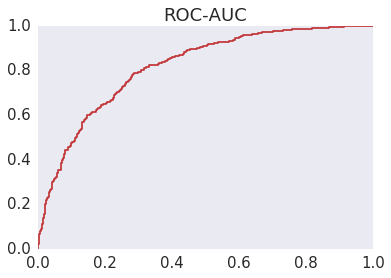

In [14]:
lr = LogisticRegression(n_jobs=-1,penalty='l2',C=10)
scaler_lr=StandardScaler()

train_X_scale=scaler_lr.fit_transform(train_X)
test_X_scale=scaler_lr.transform(test_X)

lr.fit(train_X_scale, train_y)
lr_pred=lr.predict(test_X_scale)
print accuracy_score(test_y, lr_pred)
print roc_auc_score(test_y, lr_pred)
getROC_AUC(lr,test_X_scale,test_y)


**Оценим важность признаков**

Лассо обнуляет веса ненужных признаков

In [15]:
features = pd.DataFrame(lr.coef_.reshape((19,1)),
                        index=train_X.columns, 
                        columns=['Importance']).sort_values(['Importance'], ascending=False)
features

,Importance
hasCloudCryptCertificate,0.753450
workerCount,0.674363
documentsCount,0.573049
fssdccount,0.329605
today-regdt_year,0.134424
OrgCreationDate_year,0.116165
fnsdcCount,0.110815
cnt_users,0.053416
regdt_day,0.023503
stavka,0.008874


## Случайный лес

Сделаем тоже самое для Случайного леса

In [43]:
rnd_forest=RandomForestClassifier(n_jobs=-1,random_state=17,oob_score=False)

forest_params = {'max_depth': [5,6,7,8,9,10]
                ,'max_features': [1,2,3,4,5,6,7]
                ,'min_samples_leaf':[1,2,3,5,7,8]
                ,'n_estimators':[70,80,90,100,110,125,135,150]
                }

np.random.seed(17)

cv = EvolutionaryAlgorithmSearchCV(estimator=rnd_forest,
                                   params=forest_params,
                                   scoring="accuracy",
                                   cv=5,
                                   verbose=1,
                                   population_size=100,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=10,
                                   n_jobs=8)
cv.fit(train_X, train_y)

Types [1, 1, 1, 1] and maxint [4, 7, 5, 5] detected
--- Evolve in 1440 possible combinations ---
gen	nevals	avg     	min     	max     	std      
0  	100   	0.786617	0.762142	0.801094	0.0113582
1  	55    	0.795135	0.763302	0.80242 	0.00606416
2  	70    	0.798245	0.78601 	0.80242 	0.00227329
3  	62    	0.798916	0.775236	0.80242 	0.00387987
4  	72    	0.800134	0.789823	0.80242 	0.00189792
5  	67    	0.800731	0.792972	0.80242 	0.00157104
6  	45    	0.801237	0.786508	0.80242 	0.0021469 
7  	68    	0.801762	0.789988	0.802917	0.0016558 
8  	55    	0.802234	0.797447	0.802917	0.000812801
9  	63    	0.801798	0.774242	0.802917	0.0034104  
10 	58    	0.802236	0.788662	0.802917	0.00175041 
Best individual is: {'max_features': 5, 'n_estimators': 100, 'max_depth': 9, 'min_samples_leaf': 1}
with fitness: 0.802917288248


**Построим лучшую модель**

0.792577866137
0.775478370515


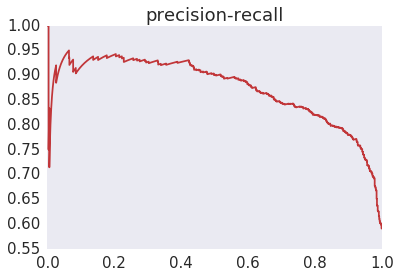

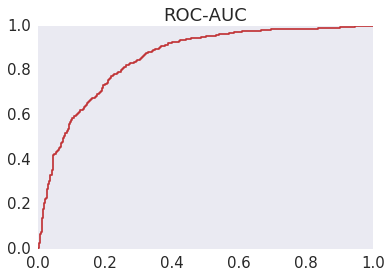

In [59]:
rnd_forest=RandomForestClassifier(n_jobs=-1,n_estimators=100,max_depth=9,max_features=5,min_samples_leaf=1,random_state=17)
rnd_forest.fit(train_X,train_y)
pred_forest=rnd_forest.predict(test_X)
print accuracy_score(test_y,pred_forest)
print roc_auc_score(test_y, pred_forest)
getROC_AUC(rnd_forest,test_X,test_y)

### Наиболее важные признаки

In [60]:
features = pd.DataFrame(rnd_forest.feature_importances_,
                        index=train_X.columns, 
                        columns=['Importance']).sort_values(['Importance'], ascending=False)
features

,Importance
hasCloudCryptCertificate,0.180447
documentsCount,0.165968
fnsdcCount,0.096610
workerCount,0.084083
fssdccount,0.067326
today-regdt_year,0.046652
today-OrgCreationDate_year,0.044166
OrgCreationDate_year,0.044025
regdt_day,0.043171
regdt_year,0.043003


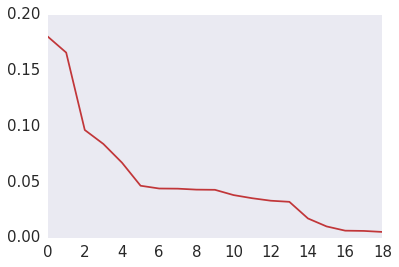

In [18]:
plt.plot(range(len(features.Importance.tolist())), 
         features.Importance.tolist())

## Обрежем наш датасет и повторим обучение

Возьмём первые 13 признаков

In [61]:
selected_attr = features.index.tolist()[0:13]
X_train = train_X[selected_attr].as_matrix()
X_test = test_X[selected_attr].as_matrix()

In [85]:
rnd_forest=RandomForestClassifier(n_jobs=-1,random_state=17,oob_score=False)

forest_params = {'max_depth': [5,6,7,8,9,10]
                ,'max_features': [1,2,3,4,5,6,7]
                ,'min_samples_leaf':[1,2,3,5,7,8]
                ,'n_estimators':range(10,150,10)
                }

np.random.seed(17)

cv = EvolutionaryAlgorithmSearchCV(estimator=rnd_forest,
                                   params=forest_params,
                                   scoring="accuracy",
                                   cv=5,
                                   verbose=1,
                                   population_size=100,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=10,
                                   n_jobs=8)
cv.fit(X_train, train_y)

Types [1, 1, 1, 1] and maxint [6, 13, 5, 5] detected


/usr/local/lib/python2.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


--- Evolve in 3528 possible combinations ---
gen	nevals	avg     	min     	max     	std       
0  	100   	0.793421	0.761479	0.803746	0.00950822
1  	50    	0.79944 	0.79264 	0.804741	0.00251292
2  	60    	0.801217	0.793303	0.804741	0.00176366
3  	63    	0.802047	0.798442	0.804741	0.00138569
4  	60    	0.802113	0.791646	0.804741	0.00247152
5  	58    	0.803186	0.797613	0.805404	0.00175916
6  	66    	0.804013	0.799436	0.805404	0.0014189 
7  	52    	0.804429	0.792309	0.805404	0.00178589
8  	64    	0.80453 	0.797282	0.805404	0.00115978
9  	60    	0.804767	0.799934	0.805404	0.000858323
10 	65    	0.804895	0.791646	0.805404	0.00160505 
Best individual is: {'max_features': 3, 'n_estimators': 70, 'max_depth': 10, 'min_samples_leaf': 1}
with fitness: 0.805403613459


Качество немного увеличилось 0.8049 vs 0.8029

**Построим модель**

0.797216699801
0.781572816308


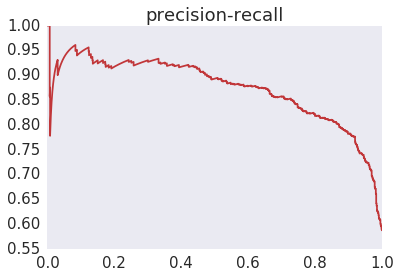

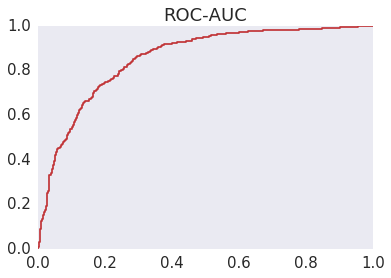

In [62]:
rnd_forest=RandomForestClassifier(n_jobs=-1,n_estimators=90,max_depth=10,max_features=3,min_samples_leaf=1,random_state=17)
rnd_forest.fit(X_train,train_y)
pred_forest=rnd_forest.predict(X_test)
print accuracy_score(test_y,pred_forest)
print roc_auc_score(test_y, pred_forest)
getROC_AUC(rnd_forest,X_test,test_y)

In [84]:
features2 = pd.DataFrame(rnd_forest.feature_importances_,
                        index=features.index.tolist()[0:13], 
                        columns=['Importance']).sort_values(['Importance'], ascending=False)
features2

,Importance
hasCloudCryptCertificate,0.166608
documentsCount,0.166554
fnsdcCount,0.098581
workerCount,0.088686
regdt_day,0.063056
fssdccount,0.062682
today-regdt_year,0.057927
OrgCreationDate_day,0.054337
regdt_year,0.051855
OrgCreationDate_month,0.050997


## Градиентрный бустинг

Попробуем градиентный бустинг над деревьями

In [34]:
g_boost=GradientBoostingClassifier(random_state=17,learning_rate=0.6)
boost_params = {'max_depth': range(1,10)
                ,'max_features': range(1,13)
                ,'min_samples_leaf':range(1,5)
                ,'n_estimators':range(10,150,10)
                ,'learning_rate':np.arange(0.01,1,0.05)
                }
np.random.seed(17)
cv = EvolutionaryAlgorithmSearchCV(estimator=g_boost,
                                   params=boost_params,
                                   scoring="accuracy",
                                   cv=5,
                                   verbose=1,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=10,
                                   n_jobs=8)
cv.fit(X_train, train_y)

Types [1, 1, 2, 1, 1] and maxint [11, 13, 19, 8, 3] detected
--- Evolve in 120960 possible combinations ---
gen	nevals	avg     	min     	max     	std      
0  	50    	0.776768	0.741422	0.797116	0.0137515
1  	31    	0.785692	0.764296	0.797116	0.00955381
2  	35    	0.792219	0.780375	0.797116	0.00407558
3  	34    	0.794126	0.776894	0.799768	0.00379242
4  	31    	0.79448 	0.746561	0.799768	0.00732842
5  	30    	0.79702 	0.784518	0.801757	0.00296068
6  	30    	0.798621	0.79264 	0.801757	0.00228377
7  	27    	0.798674	0.77507 	0.801757	0.00518811
8  	25    	0.800371	0.793303	0.802089	0.00159324
9  	31    	0.799877	0.758661	0.802089	0.00643143
10 	35    	0.800845	0.787668	0.802089	0.00239314
Best individual is: {'max_features': 3, 'n_estimators': 40, 'learning_rate': 0.060000000000000005, 'max_depth': 8, 'min_samples_leaf': 2}
with fitness: 0.802088513178


**Построим лучшую модель**

0.795228628231
0.77797394099


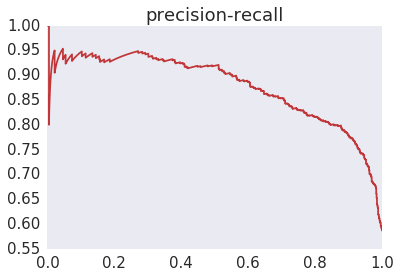

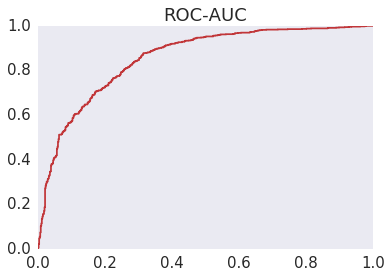

In [18]:
g_boost=GradientBoostingClassifier(random_state=17,n_estimators=40,max_depth=6,learning_rate=0.06,max_features=3,min_samples_leaf=2)
g_boost.fit(train_X,train_y)
pred_boost=g_boost.predict(test_X)
print accuracy_score(test_y,pred_boost)
print roc_auc_score(test_y, pred_boost)
getROC_AUC(g_boost,test_X,test_y)

## xgboost

In [ ]:
x_boost=xgb.XGBClassifier()
X_boost_params = {'max_depth': range(1,10)
                ,'n_estimators':range(10,150,10)
                ,'learning_rate':np.arange(0.01,0.2,0.05)
                }

np.random.seed(17)
cv = EvolutionaryAlgorithmSearchCV(estimator=x_boost,
                                   params=X_boost_params,
                                   scoring="accuracy",
                                   cv=5,
                                   verbose=1,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=10,
                                   n_jobs=8)
cv.fit(X_train, train_y)

Types [1, 2, 1] and maxint [13, 3, 8] detected
--- Evolve in 504 possible combinations ---


Process PoolWorker-5:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
Process PoolWorker-8:
Process PoolWorker-3:
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 113, in worker
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    result = (True, func(*args, **kwds))
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 65, in mapstar
    self.run()
    self.run()
    return map(*args)
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/p

    estimator.fit(X_train, y_train, **fit_params)
    verbose_eval=verbose)
  File "/usr/local/lib/python2.7/dist-packages/xgboost/sklearn.py", line 445, in fit
  File "/usr/local/lib/python2.7/dist-packages/xgboost/training.py", line 205, in train
    verbose_eval=verbose)
    xgb_model=xgb_model, callbacks=callbacks)
  File "/usr/local/lib/python2.7/dist-packages/xgboost/training.py", line 205, in train
  File "/usr/local/lib/python2.7/dist-packages/xgboost/training.py", line 76, in _train_internal
    xgb_model=xgb_model, callbacks=callbacks)
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python2.7/dist-packages/xgboost/training.py", line 76, in _train_internal
  File "/usr/local/lib/python2.7/dist-packages/xgboost/core.py", line 806, in update
    bst.update(dtrain, i, obj)
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle, iteration, dtrain.handle))
  File "/usr/local/lib/python2.7/dist-packages/xgboost/core.py", line 806, in update
    _check_call(_LIB.XGBoosterUpdat

    return map(*args)
  File "/usr/local/lib/python2.7/dist-packages/evolutionary_search/cv.py", line 104, in _evalFunction
    error_score=error_score)[0]
  File "/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_validation.py", line 458, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python2.7/dist-packages/xgboost/sklearn.py", line 445, in fit
    verbose_eval=verbose)
  File "/usr/local/lib/python2.7/dist-packages/xgboost/training.py", line 205, in train
    xgb_model=xgb_model, callbacks=callbacks)
  File "/usr/local/lib/python2.7/dist-packages/xgboost/training.py", line 76, in _train_internal
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python2.7/dist-packages/xgboost/core.py", line 806, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle, iteration, dtrain.handle))
KeyboardInterrupt
Process PoolWorker-10:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line

    verbose_eval=verbose)
    verbose_eval=verbose)
    self._target(*self._args, **self._kwargs)
Process PoolWorker-19:
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/xgboost/training.py", line 205, in train
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 113, in worker
  File "/usr/local/lib/python2.7/dist-packages/xgboost/training.py", line 205, in train
    xgb_model=xgb_model, callbacks=callbacks)
    result = (True, func(*args, **kwds))
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    xgb_model=xgb_model, callbacks=callbacks)
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/local/lib/python2.7/dist-packages/xgboost/training.py", line 76, in _train_internal
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 65, in mapstar
  File "/usr/local/lib/python2.7/dist-packages/xgboost/training.py", line 76, in _train_internal
    self._target(*self._arg

  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/pool.py", li

  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
    task = get()
    task = get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    task = get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
    racquire()
    racquire()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
Process PoolWorker-47:
Exception in thread Thread-115:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/usr/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 326, in _handle_workers

Exception in thread Thread-115:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/usr/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 326, in _handle_workers
    pool._maintain_pool()
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 230, in _maintain_pool
    self._repopulate_pool()
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 223, in _repopulate_pool
    w.start()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 130, in start
    self._popen = Popen(self)
  File "/usr/lib/python2.7/multiprocessing/forking.py", line 126, in __init__
    code = process_obj._bootstrap()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 276, in _bootstrap
    traceback.print_exc()
  File "/usr/lib/python2.7/traceback.py", line 233, in print_exc
    print_exception(etype, value,

    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    self._target(*self._args, **self._kwargs)
    task = get()
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 113, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
Exception in thread Thread-115:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/usr/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 326, in _handle_workers
    pool._maintain_pool()
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 230, in _maintain_pool
    

**Построим лучшую модель**

0.783962889331
0.766712622605


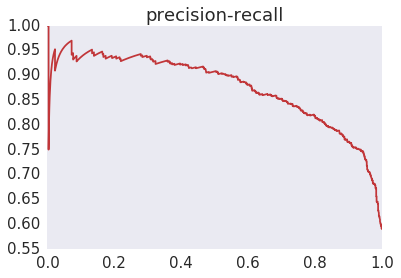

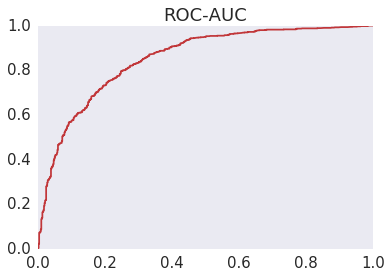

In [78]:
x_boost=xgb.XGBClassifier(n_estimators=70,learning_rate=0.06,max_depth=4)
x_boost.fit(X_train,train_y)
pred_x_boost=x_boost.predict(X_test)
print accuracy_score(test_y,pred_x_boost)
print roc_auc_score(test_y, pred_x_boost)
getROC_AUC(x_boost,X_test,test_y)

## Метод ближайших соседей

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   19.8s finished


({'knn__n_neighbors': 25}, 0.76379910492292391)
0.765407554672
0.75067303407


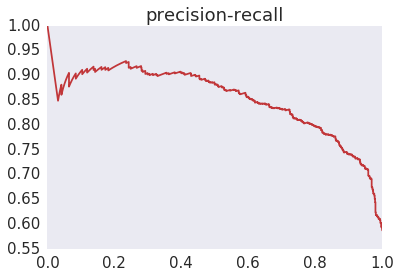

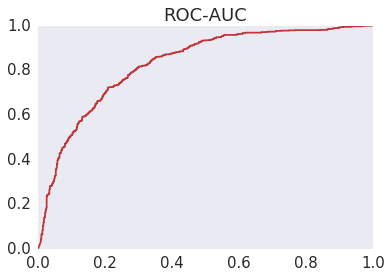

In [68]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1,weights='distance',n_neighbors=14))])
n_neighbors=range(2, 15)
knn_params = {'knn__n_neighbors': n_neighbors}
knn_grid = GridSearchCV(knn_pipe, knn_params,
                         cv=5, n_jobs=-1,
                        verbose=True)
knn_grid.fit(train_X, train_y)
print (knn_grid.best_params_, knn_grid.best_score_)
print accuracy_score(test_y, knn_grid.predict(test_X))
print roc_auc_score(test_y, knn_grid.predict(test_X))
getROC_AUC(knn_grid,test_X,test_y)

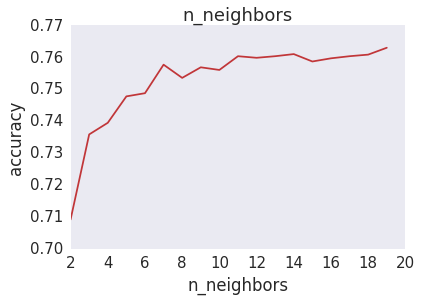

In [67]:
plt.title("n_neighbors")
plt.plot(n_neighbors,knn_grid.cv_results_['mean_test_score'])
plt.ylabel('accuracy')
plt.xlabel('n_neighbors')

## Резюме

|   |best cross_val|accuracy in test|
|---|--------------|----------------|
|LR |0.754848334162|0.756129887343  |
|RF |0.804740593403|0.797216699801  |
|GB |0.802088513178|0.795228628231  |
|Knn|0.760981269683|0.763419483101  |

Random forest показал высокую точность, поэтому построим для него следующие графики:

## График кривой обучения

In [21]:
def plot_with_std(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
        
def plot_learning_curve(clf, X, y, scoring, cv=5):
 
    train_sizes = np.linspace(0.05, 1, 20)
    n_train, val_train, val_test = learning_curve(clf,
                                                  X, y, train_sizes, cv=cv,
                                                  scoring=scoring)
    plot_with_std(n_train, val_train, label='training scores', c='green')
    plot_with_std(n_train, val_test, label='validation scores', c='red')
    plt.xlabel('Training Set Size'); plt.ylabel(scoring)
    plt.legend()

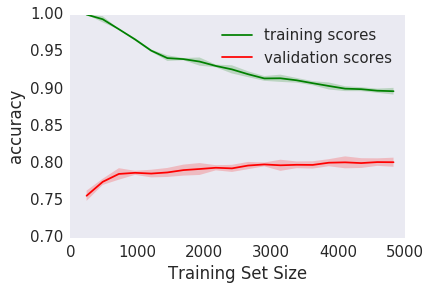

In [25]:
plot_learning_curve(RandomForestClassifier(n_jobs=-1,n_estimators=90,
                                           max_depth=10,max_features=3,
                                           min_samples_leaf=1,random_state=17),
                   X_train, train_y, scoring='accuracy', cv=5)

**Построим валидационную кривую для данных параметров леса. В качестве параметра сложности будем использовать max_depth:**

In [26]:
def plot_validation_curve(clf, X, y, cv_param_name, 
                          cv_param_values, scoring):

    val_train, val_test = validation_curve(clf, X, y, cv_param_name,
                                           cv_param_values, cv=5,
                                                  scoring=scoring)
    plot_with_std(cv_param_values, val_train, 
                  label='training scores', c='green')
    plot_with_std(cv_param_values, val_test, 
                  label='validation scores', c='red')
    plt.xlabel(cv_param_name); plt.ylabel(scoring)
    plt.legend()

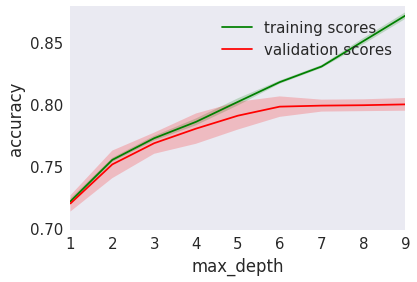

In [27]:
max_depth = range(1,10)
plot_validation_curve(RandomForestClassifier(n_jobs=-1,n_estimators=90,
                                           max_depth=10,max_features=3,
                                           min_samples_leaf=1,random_state=17), X_train, train_y, 
                      cv_param_name='max_depth', 
                      cv_param_values=max_depth,
                      scoring='accuracy')

## Стэкинг

In [86]:
from brew.base import Ensemble, EnsembleClassifier
from brew.stacking.stacker import EnsembleStack, EnsembleStackClassifier
from brew.combination.combiner import Combiner
from sklearn import clone

0.803180914513
0.793903247184


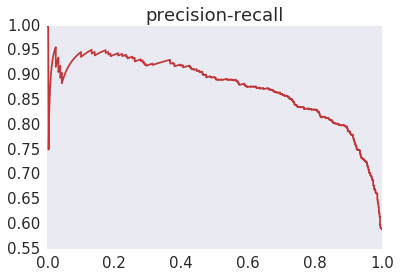

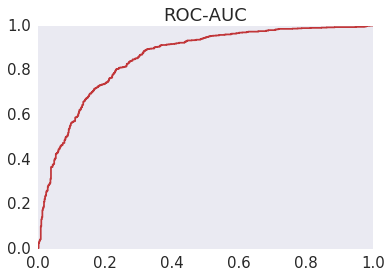

In [87]:
# Initializing Classifiers
clf1 = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1,weights='distance',n_neighbors=14))])
clf2 = RandomForestClassifier(n_jobs=-1,n_estimators=90,max_depth=10,max_features=3,min_samples_leaf=1,random_state=17)
clf3 = GradientBoostingClassifier(random_state=17,n_estimators=40,max_depth=6,learning_rate=0.06,max_features=3,min_samples_leaf=2)
clf4 = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(n_jobs=-1,penalty='l2',C=10,random_state=17))])
clf5 = RandomForestClassifier(n_jobs=-1,n_estimators=100,max_depth=10,random_state=17)

# Creating Ensemble
ensemble = Ensemble([clf1, clf2, clf3, clf4, clf5])
eclf = EnsembleClassifier(ensemble=ensemble, combiner=Combiner('mean'))

# Creating Stacking
layer_1 = Ensemble([clf1, clf2, clf3, clf4])
layer_2 = Ensemble([clone(clf5)])

stack = EnsembleStack(cv=3)

stack.add_layer(layer_1)
stack.add_layer(layer_2)

sclf = EnsembleStackClassifier(stack)


# Loading some example data
X = X_train
y = train_y

d = {yi : i for i, yi in enumerate(set(y))}
y = np.array([d[yi] for yi in y])

sclf.fit(X,y)
print accuracy_score(test_y,sclf.predict(X_test))
eclf.fit(X,y)
print accuracy_score(test_y,eclf.predict(X_test))
getROC_AUC(sclf,X_test,test_y)

## TEST

In [105]:
test.drop(axis=0,index=test[test['regdt']=='0001-01-01 00:00:00.0000000']['regdt'].index.values,inplace=True)
test[['regdt','OrgCreationDate']]=test[['regdt','OrgCreationDate']].apply(pd.to_datetime)
test.dropna(axis=0, how='any',inplace=True)

columns = test.select_dtypes(['floating']).columns
test[columns] = test[columns].astype('int64')

test['regdt_year']=pd.DatetimeIndex(test['regdt']).year
test['regdt_month']=pd.DatetimeIndex(test['regdt']).month
test['regdt_day']=pd.DatetimeIndex(test['regdt']).day

test['OrgCreationDate_year']=pd.DatetimeIndex(test['OrgCreationDate']).year
test['OrgCreationDate_month']=pd.DatetimeIndex(test['OrgCreationDate']).month
test['OrgCreationDate_day']=pd.DatetimeIndex(test['OrgCreationDate']).day

test.drop(axis=1,columns=['regdt','OrgCreationDate'],inplace=True)

test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2536 entries, 0 to 2541
Data columns (total 15 columns):
id                          2536 non-null int64
taxactionSystem             2536 non-null object
workerCount                 2536 non-null int64
fssdccount                  2536 non-null int64
pfrdcCount                  2536 non-null int64
fnsdcCount                  2536 non-null int64
hasCloudCryptCertificate    2536 non-null int64
documentsCount              2536 non-null int64
cnt_users                   2536 non-null int64
regdt_year                  2536 non-null int64
regdt_month                 2536 non-null int64
regdt_day                   2536 non-null int64
OrgCreationDate_year        2536 non-null int64
OrgCreationDate_month       2536 non-null int64
OrgCreationDate_day         2536 non-null int64
dtypes: int64(14), object(1)
memory usage: 317.0+ KB


In [126]:
test.head()

,id,taxactionSystem,workerCount,fssdccount,pfrdcCount,fnsdcCount,hasCloudCryptCertificate,documentsCount,cnt_users,regdt_year,regdt_month,regdt_day,OrgCreationDate_year,OrgCreationDate_month,OrgCreationDate_day
0,106879,ОСНО,0,1,0,2,1,5,1,2014,11,1,2015,3,31
1,108820,"УСН, Доходы за вычетом расходов 6%",2,1,2,1,1,5,0,2012,2,25,2015,1,15
2,104079,"УСН, Доходы за вычетом расходов 15%",0,1,1,2,0,6,1,2014,6,9,2014,5,15
3,106924,"УСН, Доходы за вычетом расходов 15%",1,0,0,0,0,5,0,2011,9,11,2014,4,9
4,106335,"УСН, Доходы за вычетом расходов 5%",3,2,2,2,0,7,0,2005,6,4,2016,4,3
